<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Natural Language Processing (NLP)
## *Data Science Unit 4 Sprint 1 Assignment 1*

Your goal in this assignment: find the attributes of the best & worst coffee shops in the dataset. The text is fairly raw: dates in the review, extra words in the `star_rating` column, etc. You'll probably want to clean that stuff up for a better analysis. 

Analyze the corpus of text using text visualizations of token frequency. Try cleaning the data as much as possible. Try the following techniques: 
- Lemmatization
- Custom stopword removal

Keep in mind the attributes of good tokens. Once you have a solid baseline, layer in the star rating in your visualization(s). Key part of this assignment - produce a write-up of the attributes of the best and worst coffee shops. Based on your analysis, what makes the best the best and the worst the worst. Use graphs and numbesr from your analysis to support your conclusions. There should be plenty of markdown cells! :coffee:

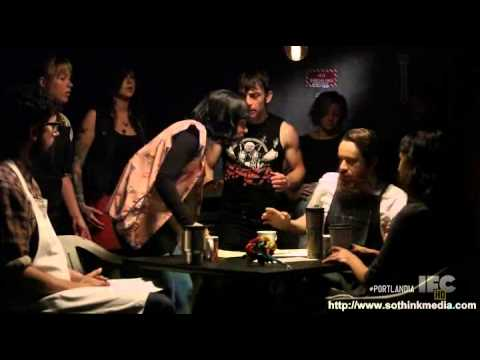

In [2]:
from IPython.display import YouTubeVideo

YouTubeVideo('Jml7NVYm8cs')

In [3]:
%pwd

'/Users/chris/ipynbs/u4nlp/module1-text-data'

In [2]:
import pandas as pd

url = "https://raw.githubusercontent.com/LambdaSchool/DS-Unit-4-Sprint-1-NLP/master/module1-text-data/data/yelp_coffeeshop_review_data.csv"

shops = pd.read_csv(url)
shops.head()

,coffee_shop_name,full_review_text,star_rating
0,The Factory - Cafe With a Soul,11/25/2016 1 check-in Love love loved the atm...,5.0 star rating
1,The Factory - Cafe With a Soul,"12/2/2016 Listed in Date Night: Austin, Ambia...",4.0 star rating
2,The Factory - Cafe With a Soul,11/30/2016 1 check-in Listed in Brunch Spots ...,4.0 star rating
3,The Factory - Cafe With a Soul,11/25/2016 Very cool decor! Good drinks Nice ...,2.0 star rating
4,The Factory - Cafe With a Soul,12/3/2016 1 check-in They are located within ...,4.0 star rating


In [3]:
shops['coffee_shop_name'].unique()

array(['The Factory - Cafe With a Soul ',
       'The Marvelous Vintage Tea Party Co. ', 'Vintage Heart Coffee ',
       'Fleet Coffee ', 'Mozart’s Coffee Roasters ',
       'Summermoon Coffee Bar ', 'Monkey Nest Coffee ',
       'Apanas Coffee & Beer ', 'Corona Coffee ', 'Café Crème ',
       'Brian’s Brew ', 'Legend Coffee ', 'Venezia Italian Gelato ',
       'Epoch Coffee ', 'Houndstooth Coffee ', 'Caffé Medici ',
       'Flitch Coffee ', 'Caffe Medici ', 'Holy Grounds ',
       'Figure 8 Coffee Purveyors ', 'Mañana Coffee & Juice ',
       'Summer Moon Coffee Bar ', 'Fat Cats Organic Coffee And Dessert ',
       'Flat Track Coffee ', 'Mary’s Cafe ', 'Anderson’s Coffee Company ',
       'Flightpath Coffeehouse ', 'Third Coast Coffee Roasting Company ',
       'Bennu Coffee ', 'Dolce Neve ', 'Thunderbird Coffee ', 'Halcyon ',
       'Cherrywood Coffeehouse ', 'Jo’s Coffee ',
       'Arturo’s Underground Cafe ', 'Patika ', 'Cenote ',
       'The Hideout Coffeehouse ', 'Lucky Lab Coffe

In [6]:
shops['star_rating'].unique()

array([' 5.0 star rating ', ' 4.0 star rating ', ' 2.0 star rating ',
       ' 3.0 star rating ', ' 1.0 star rating '], dtype=object)

In [4]:
shops['rating'] = shops['star_rating'].apply(lambda x: int(x[1]))
shops.head()

,coffee_shop_name,full_review_text,star_rating,rating
0,The Factory - Cafe With a Soul,11/25/2016 1 check-in Love love loved the atm...,5.0 star rating,5
1,The Factory - Cafe With a Soul,"12/2/2016 Listed in Date Night: Austin, Ambia...",4.0 star rating,4
2,The Factory - Cafe With a Soul,11/30/2016 1 check-in Listed in Brunch Spots ...,4.0 star rating,4
3,The Factory - Cafe With a Soul,11/25/2016 Very cool decor! Good drinks Nice ...,2.0 star rating,2
4,The Factory - Cafe With a Soul,12/3/2016 1 check-in They are located within ...,4.0 star rating,4


In [5]:
shops['isgood'] = (shops['rating'] > 3).astype(int)
shops.head()

,coffee_shop_name,full_review_text,star_rating,rating,isgood
0,The Factory - Cafe With a Soul,11/25/2016 1 check-in Love love loved the atm...,5.0 star rating,5,1
1,The Factory - Cafe With a Soul,"12/2/2016 Listed in Date Night: Austin, Ambia...",4.0 star rating,4,1
2,The Factory - Cafe With a Soul,11/30/2016 1 check-in Listed in Brunch Spots ...,4.0 star rating,4,1
3,The Factory - Cafe With a Soul,11/25/2016 Very cool decor! Good drinks Nice ...,2.0 star rating,2,0
4,The Factory - Cafe With a Soul,12/3/2016 1 check-in They are located within ...,4.0 star rating,4,1


In [6]:
gtxts = shops[shops['isgood'] == 1]['full_review_text']
btxts = shops[shops['isgood'] == 0]['full_review_text']

## How do we want to analyze these coffee shop tokens? 

- Overall Word / Token Count
- View Counts by Rating 
- *Hint:* a 'bad' coffee shops has a rating betweeen 1 & 3 based on the distribution of ratings. A 'good' coffee shop is a 4 or 5. 

In [15]:
import re
import spacy
nlp = spacy.load('en_core_web_lg')

def tokenize(text):
    tokens = re.sub(r'[^a-zA-Z ^0-9]', '', text)
    tokens = tokens.lower().split()
    return [t for t in tokens if t not in nlp.Defaults.stop_words]

gtokes = gtxts.apply(tokenize)
btokes = btxts.apply(tokenize)

In [16]:
gtokes

0       [11252016, 1, checkin, love, love, loved, atmo...
1       [1222016, listed, date, night, austin, ambianc...
2       [11302016, 1, checkin, listed, brunch, spots, ...
4       [1232016, 1, checkin, located, northcross, mal...
5       [11202016, 1, checkin, cute, cafe, think, mome...
6       [10272016, 2, checkins, listed, nuptial, coffe...
7       [1122016, 2, checkins, love, place, 5, stars, ...
9       [11102016, 3, checkins, place, shown, social, ...
10      [10222016, 1, checkin, listed, americano, aver...
13      [1252016, cute, little, cafe, ive, driven, pla...
14      [11132016, beautiful, eccentric, coffee, shop,...
15      [1192016, 1, checkin, listed, search, fantasti...
16      [1162016, love, atmosphere, frequent, coffee, ...
17      [10252016, 1, checkin, check, video, review, y...
18      [10152016, 1, checkin, note, come, youre, look...
19      [1212016, aesthetic, place, love, corner, coff...
20      [10122016, 1, checkin, checked, factory, past,...
21      [10102

326

In [18]:
from collections import Counter

def count(docs):

        word_counts = Counter()
        appears_in = Counter()
        
        total_docs = len(docs)

        for doc in docs:
            word_counts.update(doc)
            appears_in.update(set(doc))

        temp = zip(word_counts.keys(), word_counts.values())
        
        wc = pd.DataFrame(temp, columns = ['word', 'count'])

        wc['rank'] = wc['count'].rank(method='first', ascending=False)
        total = wc['count'].sum()

        wc['pct_total'] = wc['count'].apply(lambda x: x / total)
        
        wc = wc.sort_values(by='rank')
        wc['cul_pct_total'] = wc['pct_total'].cumsum()

        t2 = zip(appears_in.keys(), appears_in.values())
        ac = pd.DataFrame(t2, columns=['word', 'appears_in'])
        wc = ac.merge(wc, on='word')

        wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs)
        
        return wc.sort_values(by='rank')

gcounts = count(gtokes)
bcounts = count(btokes)

## Can visualize the words with the greatest difference in counts between 'good' & 'bad'?

Couple Notes: 
- Rel. freq. instead of absolute counts b/c of different numbers of reviews
- Only look at the top 5-10 words with the greatest differences


In [19]:
gcounts.head(10)

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
26,coffee,3933,8234,1.0,0.028068,0.028068,0.640554
147,place,2939,4314,2.0,0.014706,0.042774,0.478664
107,great,2492,3453,3.0,0.011771,0.054545,0.405863
184,good,2192,3096,4.0,0.010554,0.065099,0.357003
216,like,1559,2212,5.0,0.007540,0.072639,0.253909
48,austin,1547,1969,6.0,0.006712,0.079351,0.251954
29,1,1713,1793,7.0,0.006112,0.085463,0.278990
24,love,1322,1725,8.0,0.005880,0.091344,0.215309
42,checkin,1600,1605,9.0,0.005471,0.096815,0.260586
148,friendly,1399,1462,10.0,0.004984,0.101799,0.227850


In [20]:
bcounts.head(10)

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
28,coffee,944,2119,1.0,0.025629,0.025629,0.639566
37,place,720,1112,2.0,0.013449,0.039078,0.487805
1,good,596,877,3.0,0.010607,0.049685,0.403794
34,like,565,876,4.0,0.010595,0.060280,0.382791
82,food,310,484,5.0,0.005854,0.066134,0.210027
229,time,353,478,6.0,0.005781,0.071915,0.239160
109,great,344,466,7.0,0.005636,0.077551,0.233062
193,dont,352,449,8.0,0.005431,0.082982,0.238482
8,service,345,445,9.0,0.005382,0.088364,0.233740
49,im,314,445,10.0,0.005382,0.093746,0.212737


In [21]:
import squarify
import matplotlib.pyplot as plt

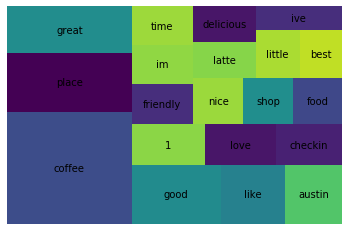

In [22]:
gtop = gcounts[gcounts['rank'] <= 20]
squarify.plot(sizes=gtop['pct_total'], label=gcounts['word'])
plt.axis('off')
plt.show()

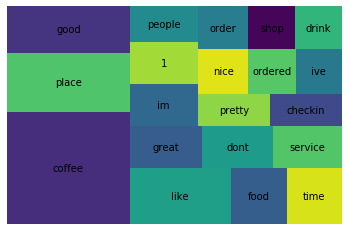

In [23]:
btop = bcounts[bcounts['rank'] <= 20]
squarify.plot(sizes=btop['pct_total'], label=bcounts['word'])
plt.axis('off')
plt.show()

## Stretch Goals

* Analyze another corpus of documents - such as Indeed.com job listings ;).
* Play with the Spacy API to
 - Extract Named Entities
 - Extracting 'noun chunks'
 - Attempt Document Classification with just Spacy
 - *Note:* This [course](https://course.spacy.io/) will be of interesting in helping you with these stretch goals. 
* Try to build a plotly dash app with your text data 

